In [11]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [12]:
dfs_all = pd.read_pickle('data/saturated_pulses_data.pkl')

In [13]:
thegroup = dfs_all.groupby('lake_nr')
summarydf = pd.DataFrame({
    'file': thegroup['fn'].first(),
    'quality': thegroup['quality'].first(),
    'sat_frac': thegroup['frac_sat'].first(),
    'sat_max': thegroup['ratio_saturation'].apply(np.percentile,**{'q': 95})
})
filtered_df = summarydf[(summarydf.sat_max > 3) & (summarydf.sat_frac>0.3)].sort_values(by='quality', ascending=False)

20 data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5 

-70.95678236189684 71.51003776445101
2019-01-15T17:57:57Z
ATL03_20190115175225_02790210_006_02.h5
279
gt2r


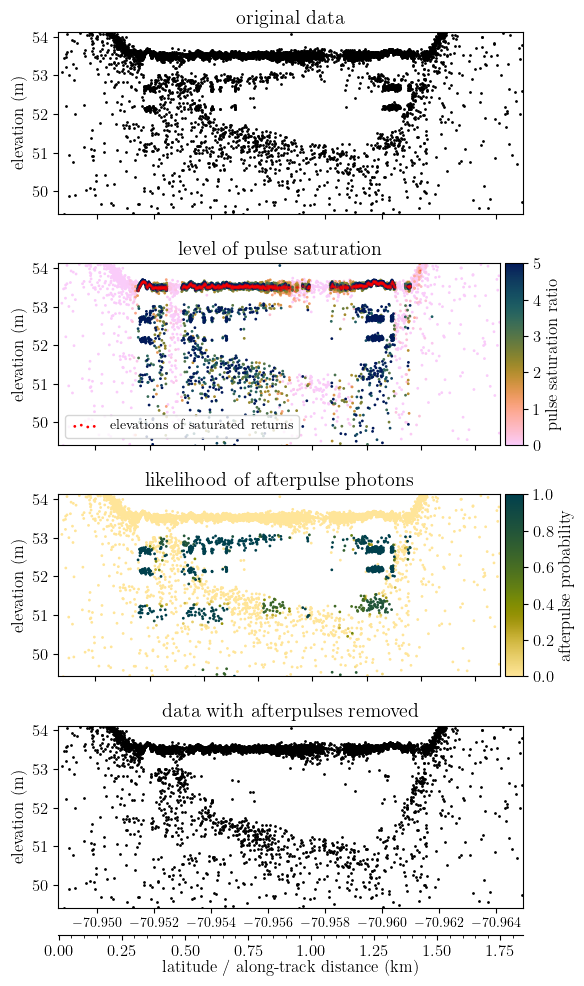

_____________________________________________________________

21 data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5 

69.01888751162573 -49.04438938557605
2019-06-17T06:45:19Z
ATL03_20190617064249_12220303_006_02.h5
1222
gt2l


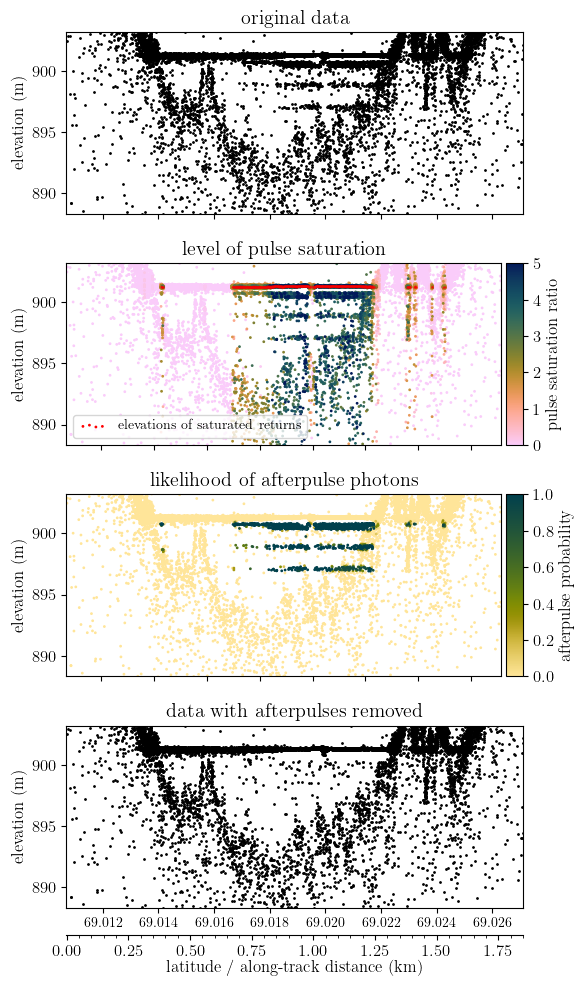

_____________________________________________________________

22 data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5 

71.6999275127194 -50.37072059596835
2019-08-22T16:25:22Z
ATL03_20190822162310_08490405_006_02.h5
849
gt2l


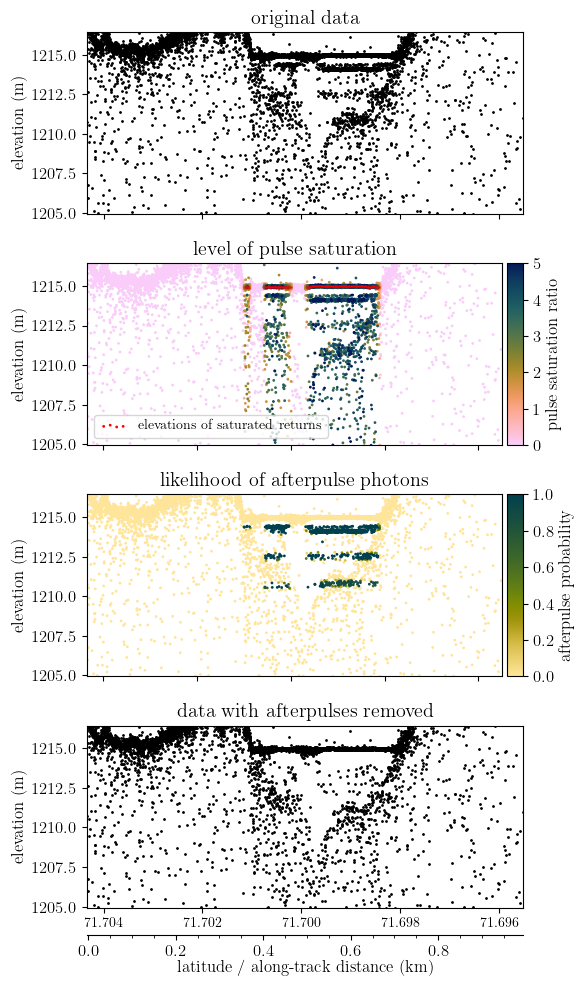

_____________________________________________________________



In [17]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

start = 20
end = 40
files = np.array(filtered_df.file)[start:end]

# files = np.array(filtered_df.file)[[1]]

files = [
    'data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5',
    'data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5',
    'data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5',
]

for i, fn in enumerate(files):

    print(start+i, fn, '\n')

    lk = dictobj(read_melt_lake_h5(fn))

    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)
    
    df = lk.photon_data
    df['pulseid'] = df.apply(lambda row: 1000*row.mframe+row.ph_id_pulse, axis=1)
    df_mframe = lk.mframe_data
    xatcmin = df.xatc.min()
    df.xatc -= xatcmin
    surf_elev = lk.surface_elevation

    ylms = np.array((-1.7*lk.max_depth, 0.25*lk.max_depth)) + surf_elev
    xlms = (df.lat.min(), df.lat.max())
    
    fig, axs = plt.subplots(figsize=[6, 10], dpi=100, nrows=4, ncols=1, sharex=True)

    ax = axs[0]
    ax.scatter(df.lat, df.h, s=1, c='k', alpha=1)
    ax.set_title('original data')

    ax = axs[1]
    df_sat = df.sort_values(by='sat_ratio')
    scatt = ax.scatter(df_sat.lat, df_sat.h, s=1, alpha=1, c=df_sat.sat_ratio, cmap=cmc.batlow_r, vmin=0, vmax=5)
    dfpulse = df.groupby('pulseid').median()
    dfpulse = dfpulse[dfpulse.sat_ratio > 1.0]
    satelevs = ax.scatter(dfpulse.lat, dfpulse.sat_elev, s=0.5, c='r', alpha=0.3, label='elevations of saturated returns')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('pulse saturation ratio')
    ax.set_title('level of pulse saturation')
    satelevs = ax.scatter(-9999, -9999, s=1, c='r', alpha=1, label='elevations of saturated returns')
    ax.legend(handles=[satelevs], loc='lower left', fontsize=10, scatterpoints=4)

    ax = axs[2]
    df_prob = df.sort_values(by='prob_afterpulse')
    scatt = ax.scatter(df_prob.lat, df_prob.h, s=1, alpha=1, c=df_prob.prob_afterpulse, cmap=cmc.bamako_r, vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('afterpulse probability')
    ax.set_title('likelihood of afterpulse photons')
    ymin, ymax = ax.get_ylim()
    mframe_bounds_xatc = np.array(list(df_mframe['xatc_min']) + [df_mframe['xatc_max'].iloc[-1]]) - xatcmin
    for xmframe in mframe_bounds_xatc:
        ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

    ax = axs[3]
    df['remove_afterpulse'] = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    dfp = df[~df.remove_afterpulse]
    scatt = ax.scatter(dfp.lat, dfp.h, s=1, c='k', alpha=1)
    ax.set_title('data with afterpulses removed')
    
    for ax in axs.flatten():
        ax.set_xlim(xlms)
        ax.set_ylim(ylms)
        ax.set_ylabel('elevation (m)')
        
    axs[3].ticklabel_format(useOffset=False, style='plain')
    axs[3].tick_params(axis='x', labelsize=10)

    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # flip x-axis if track is descending, to make along-track distance go from left to right
    if gt.lat.iloc[0] > gt.lat.iloc[-1]:
        for axx in axs.flatten():
            axx.set_xlim(np.flip(np.array(xlms)))

    # add along-track distance
    lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    _lat = np.array(lx.lat)
    _xatc = np.array(lx.x10) / 1e3
    def lat2xatc(l):
        return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    def xatc2lat(x):
        return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
    secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    secax.tick_params(axis='both', which='major')
    secax.ticklabel_format(useOffset=False, style='plain')
    
    fig.tight_layout()
    plt.savefig('plots/afterpulse_removal_%i.jpg' % (i+1), dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')


In [9]:
gt

,x10,lat,lon
0,0.0,71.704309,-50.368882
1,10.0,71.704245,-50.368908
2,20.0,71.704154,-50.368944
3,30.0,71.704068,-50.368980
4,40.0,71.703977,-50.369017
...,...,...,...
95,950.0,71.695892,-50.372422
96,960.0,71.695807,-50.372457
97,970.0,71.695714,-50.372495
98,980.0,71.695628,-50.372530
